# Find stars

This notebook combines the procedures developed in `Background.ipynb` and `White_light_images.ipynb` notebooks to build images suitable for star finding. Then it applies `photutils` tools to find star images and build  tables with centroid locations. 

There is also a statistical analysis to see how star shapes depend on the RGB normalization coefficients. 

Later we proceed to find stars in two contiguous images in the sequence, to see how to correlate the detections that are stored in two separate tables.

In [1]:
%pylab notebook
%matplotlib notebook

import os, glob

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from astropy.table import Table, vstack
from astropy.io import fits
from astropy.stats import SigmaClip

import photutils
from photutils import Background2D, ModeEstimatorBackground, DAOStarFinder, CircularAperture

import rawpy

Populating the interactive namespace from numpy and matplotlib


In [2]:
# test image
fname = '../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03779.ARW'
raw = rawpy.imread(fname)
imarray = raw.raw_image_visible.astype(float)

In [3]:
# masks that isolate the RGB pixels 
colors_array = raw.raw_colors_visible
mask = np.ones(shape=colors_array.shape)

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

Use normalization factors determined in `White_light_images.ipynb` notebook for the same raw image.

In a more flexible application, one should include the minimization step as part of this workflow.

In [4]:
# normalization factors
red_norm = 1.321875  # smooth background
green_norm = 1.
blue_norm = 1.27695312

# red_norm = 1.36  # max roundness
# green_norm = 1.
# blue_norm = 1.46

In [5]:
# build raw image with "normalized" RGB subarrays. Explictly ignore flat field.
raw_norm_1 = imarray * (red_mask * red_norm)
raw_norm_2 = raw_norm_1 + imarray * (green_mask * green_norm)
raw_norm = raw_norm_2 + imarray * (blue_mask * blue_norm)

In [6]:
# handle saturated pixels
raw_norm = np.where(imarray > 16380, imarray, raw_norm)

<IPython.core.display.Javascript object>


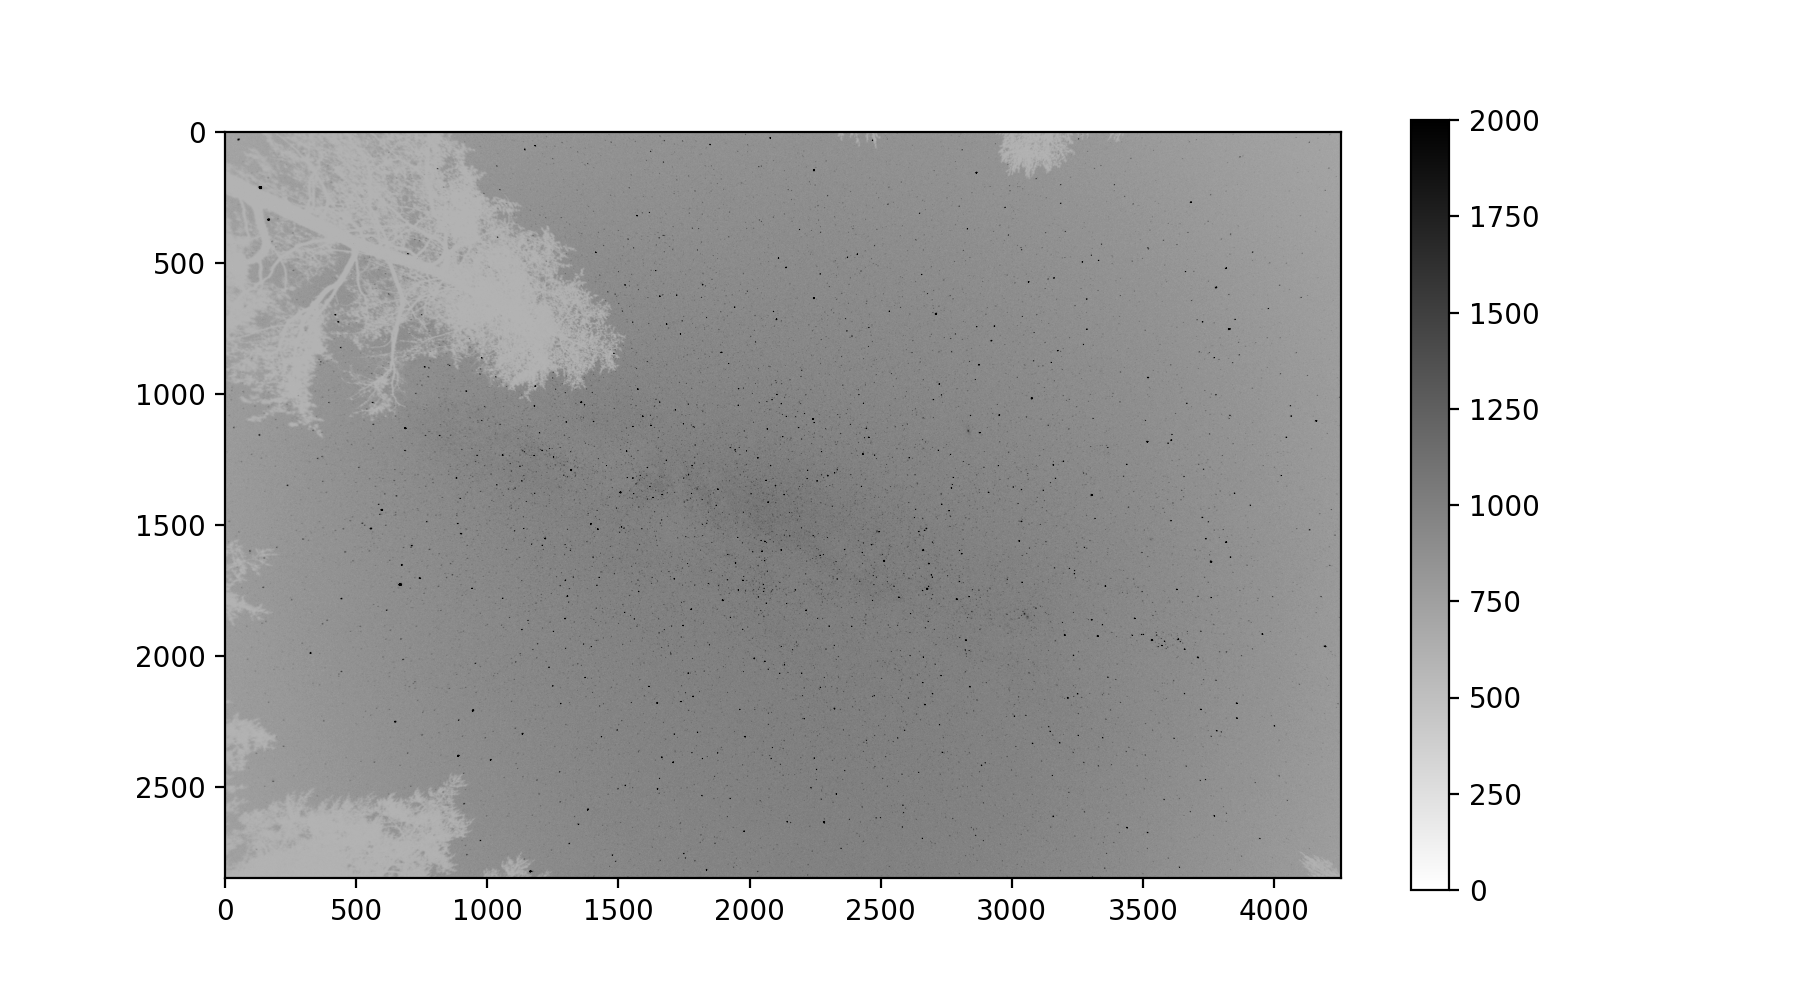

21321.84375
Relative standard deviation of a smooth patch:  0.08636338453617722


In [7]:
plt.figure(figsize=[9, 5])
print(np.max(raw_norm))
plt.imshow(raw_norm, vmin=0, vmax=2000, cmap='binary')
# plt.imshow(raw_norm, vmax=28000, cmap='gist_stern')
plt.colorbar()

section = raw_norm[750:810,3320:3380]
print("Relative standard deviation of a smooth patch: ", np.std(section) / np.median(section))

In [8]:
# estimate background
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = ModeEstimatorBackground()
bkg = Background2D(raw_norm, (100, 100), filter_size=(5, 5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

<IPython.core.display.Javascript object>


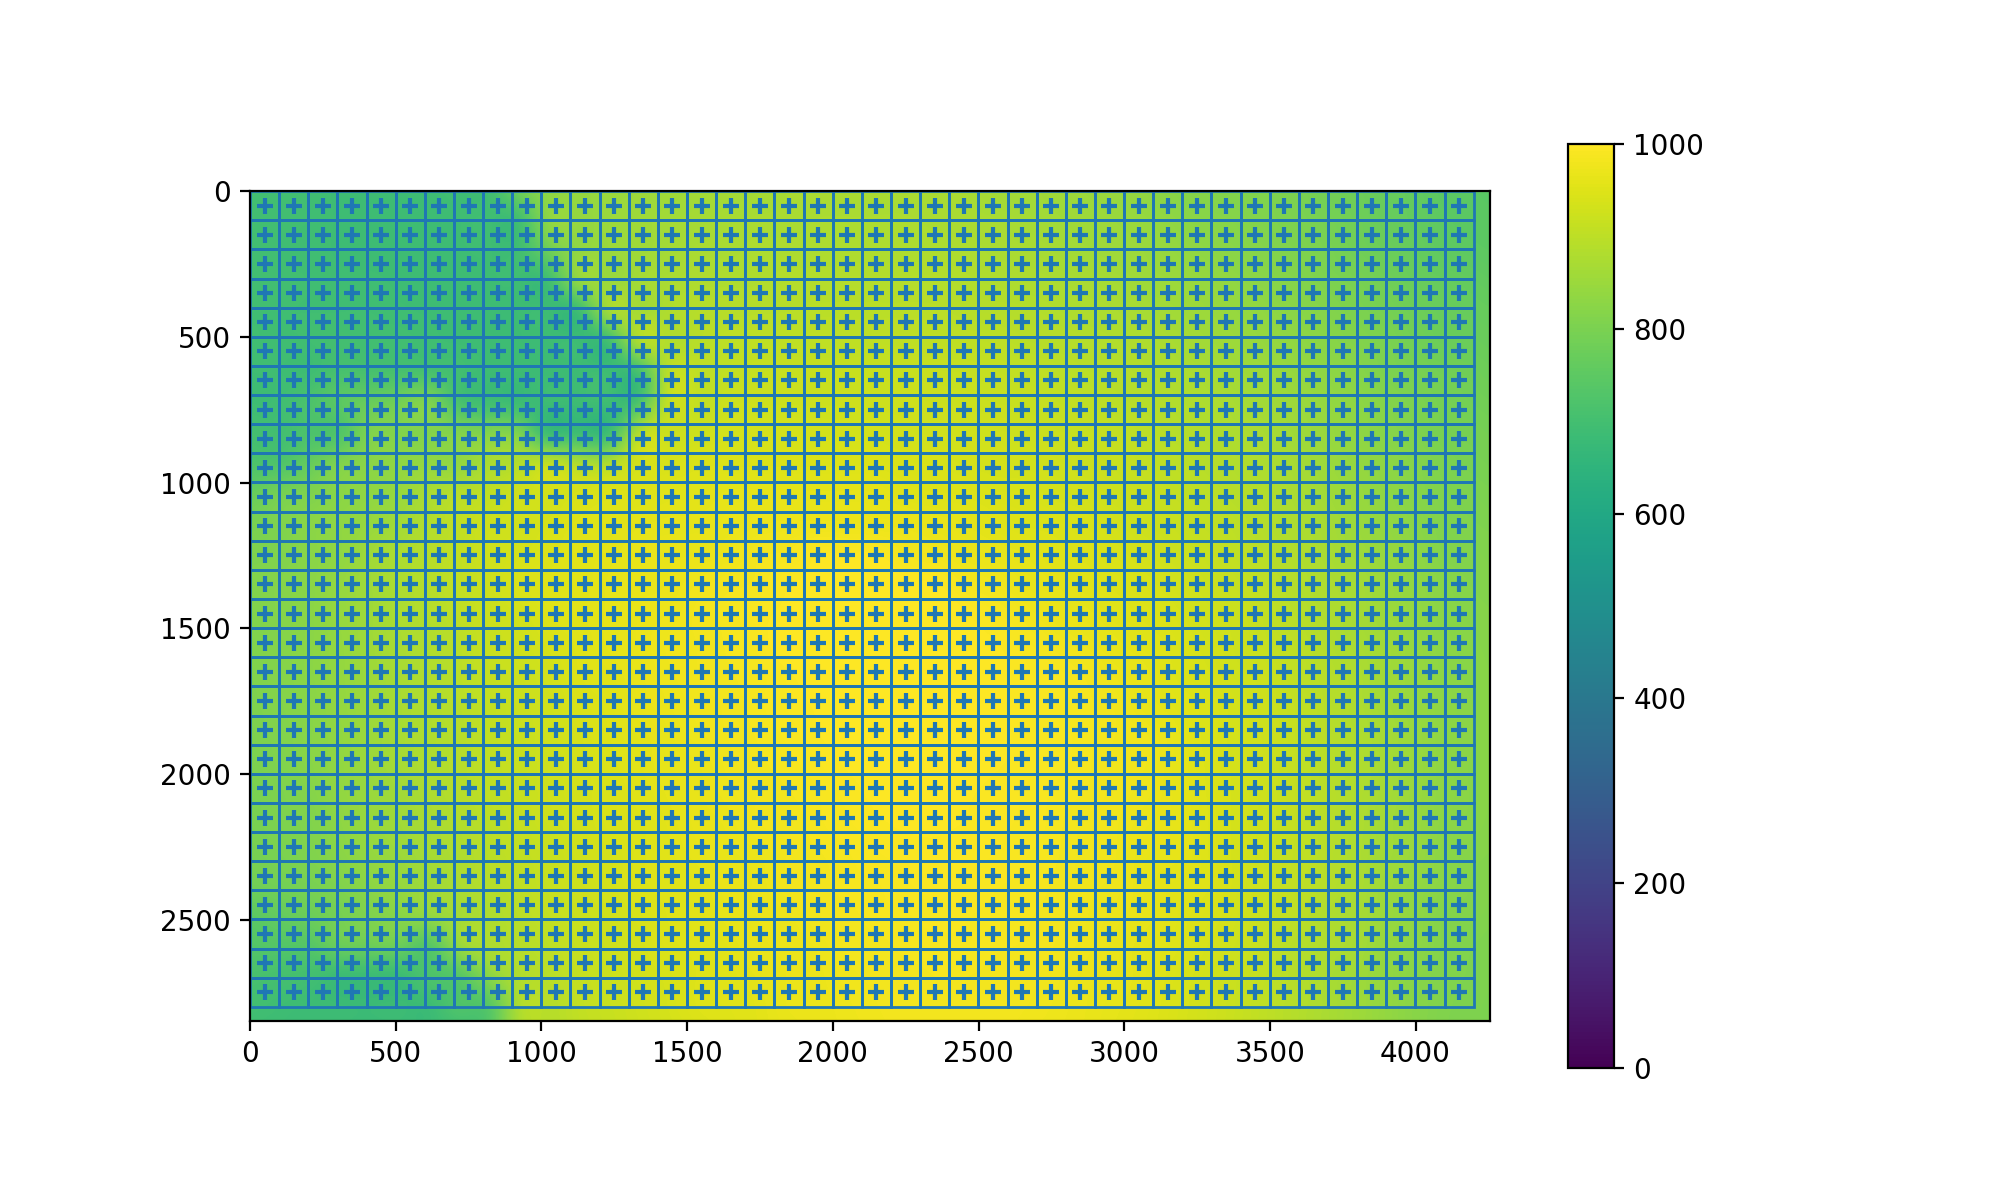

In [9]:
plt.figure(figsize=[10, 6])
plt.imshow(bkg.background, vmin=0, vmax=1000)
bkg.plot_meshes(outlines=True, color='#1f77b4')
plt.colorbar()

In [10]:
subtracted = raw_norm - bkg.background

<IPython.core.display.Javascript object>


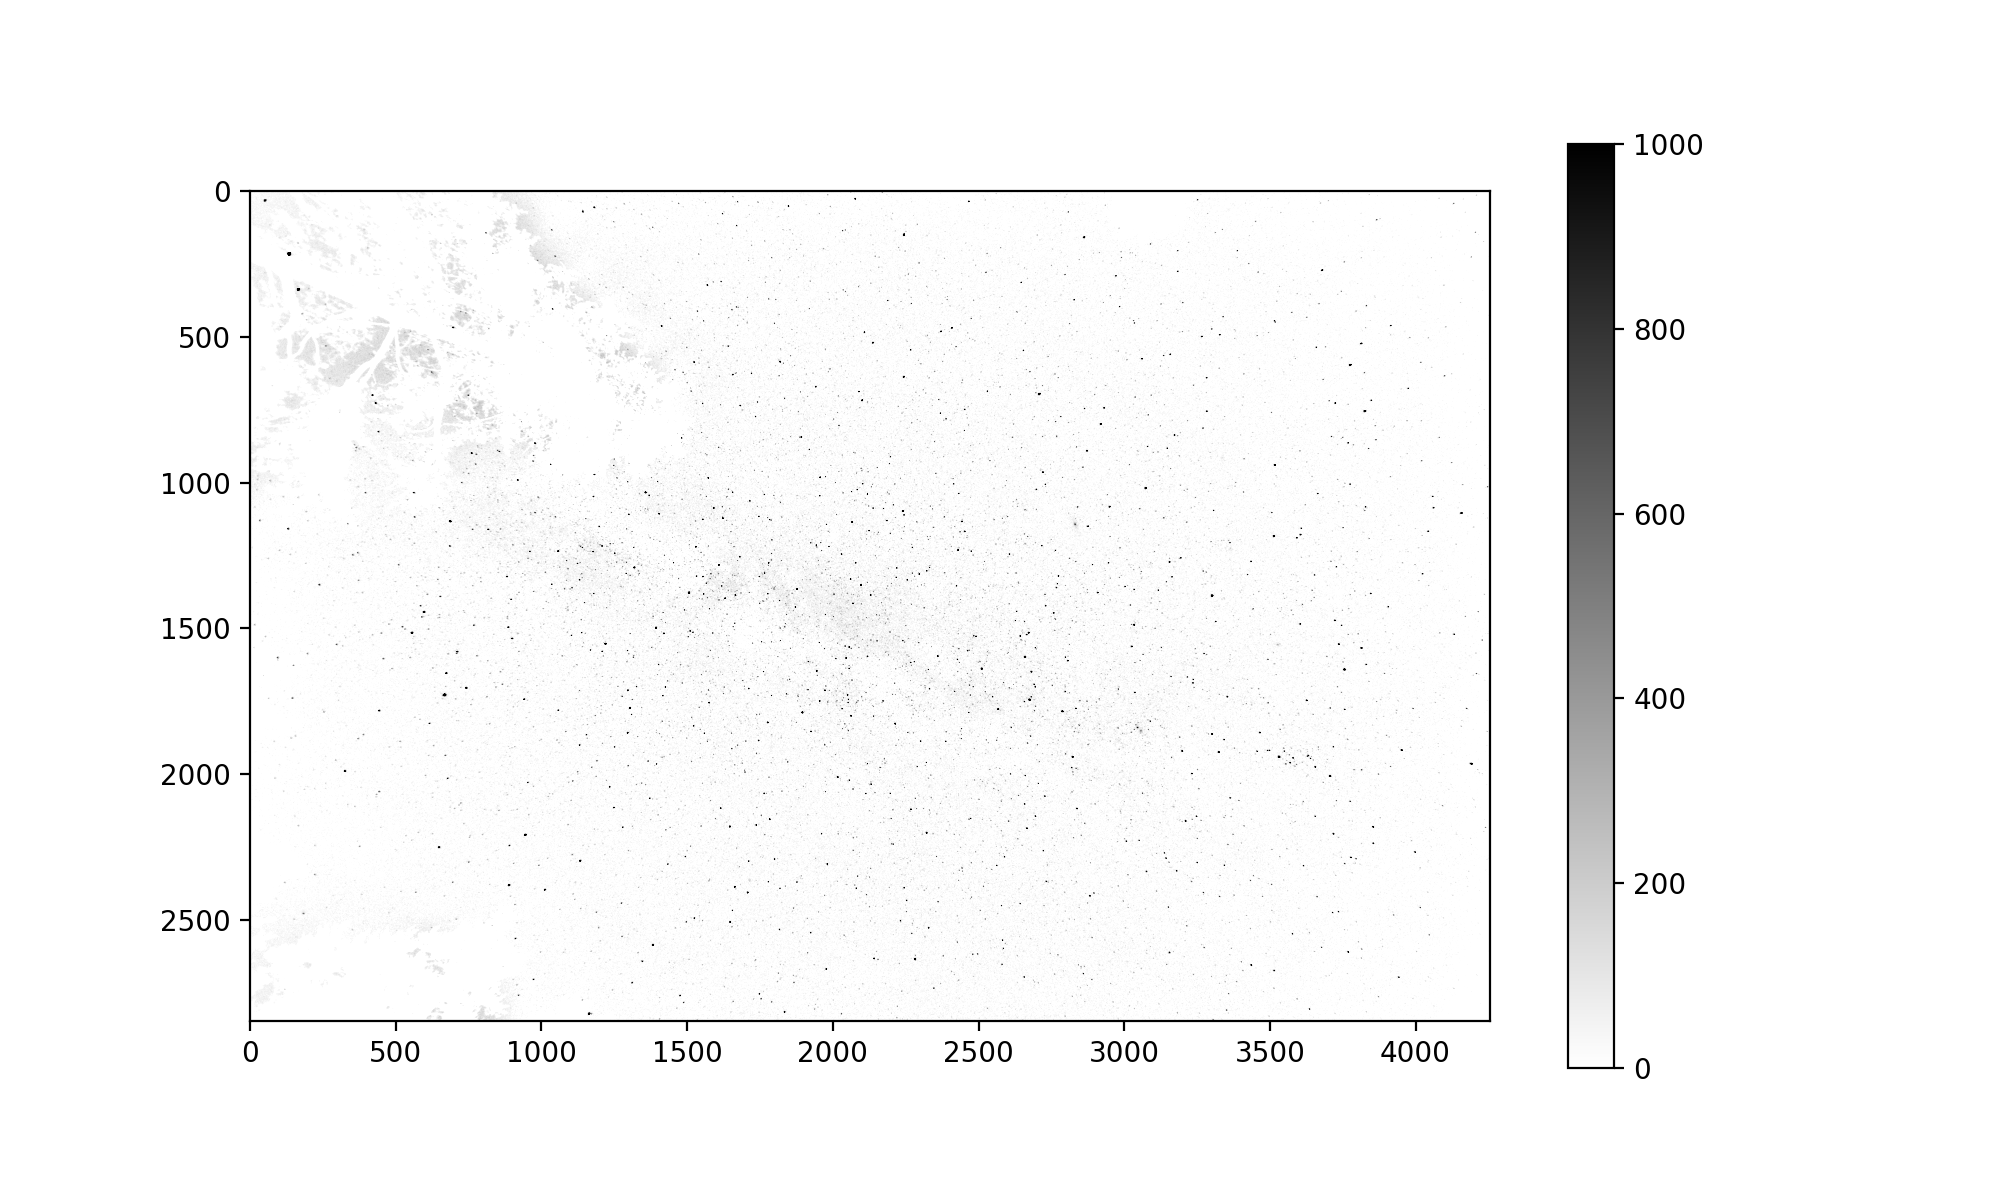

In [11]:
plt.figure(figsize=[10, 6])
plt.imshow(subtracted, vmin=0, vmax=1000, cmap='binary')
plt.colorbar()

In [12]:
# find star images
daofind = DAOStarFinder(fwhm=3.0, 
                        threshold=10.*bkg.background_rms_median)  

# can't be too strict with these. Many images are very non-circular 
# and non-Gaussian due to strong undersampling
#                         sharplo=0.1, sharphi=0.8,
#                         roundlo=-0.7, roundhi=0.7,

sources = daofind(subtracted)  

In [13]:
for col in sources.colnames:  
    sources[col].info.format = '%.4g'  # for consistent table output
print(sources)  

 id  xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag   
---- --------- --------- --------- ---------- ... --- --------- ----- --------
   1      2169     4.002    0.7567     0.3914 ...   0      1664 1.749  -0.6071
   2      1983     12.24    0.6502     0.6185 ...   0      1343 1.492  -0.4343
   3      1657     18.49    0.8794     0.4014 ...   0      1823 1.758  -0.6128
   4      4081     24.36    0.7313    -0.4786 ...   0       970 1.143  -0.1446
   5      2077     25.77    0.7395     0.4414 ...   0 1.184e+04 13.27   -2.807
   6     49.89     30.94     0.321    -0.5902 ...   0      2533 3.458   -1.347
   7      49.3     34.56     0.476    -0.1429 ...   0      1186 1.074 -0.07727
   8      2467     34.86    0.4616    0.08791 ...   0      7163 10.96   -2.599
   9      1673     35.86    0.6333     0.9116 ...   0      2626 3.107   -1.231
  10      1563     39.08    0.6514     0.3767 ...   0      1100 1.352  -0.3275
 ...       ...       ...       ...        ... ... ..

In [14]:
# statistics
print("Mean roundness: ", np.average(sources['roundness1']), "stdev: ", np.std(sources['roundness1']))
print("Mean sharpness: ", np.average(sources['sharpness']), "stdev: ", np.std(sources['sharpness']))

Mean roundness:  -0.01723407171385183 stdev:  0.37480376822789774
Mean sharpness:  0.6768454431834919 stdev:  0.21130411168232005


<IPython.core.display.Javascript object>


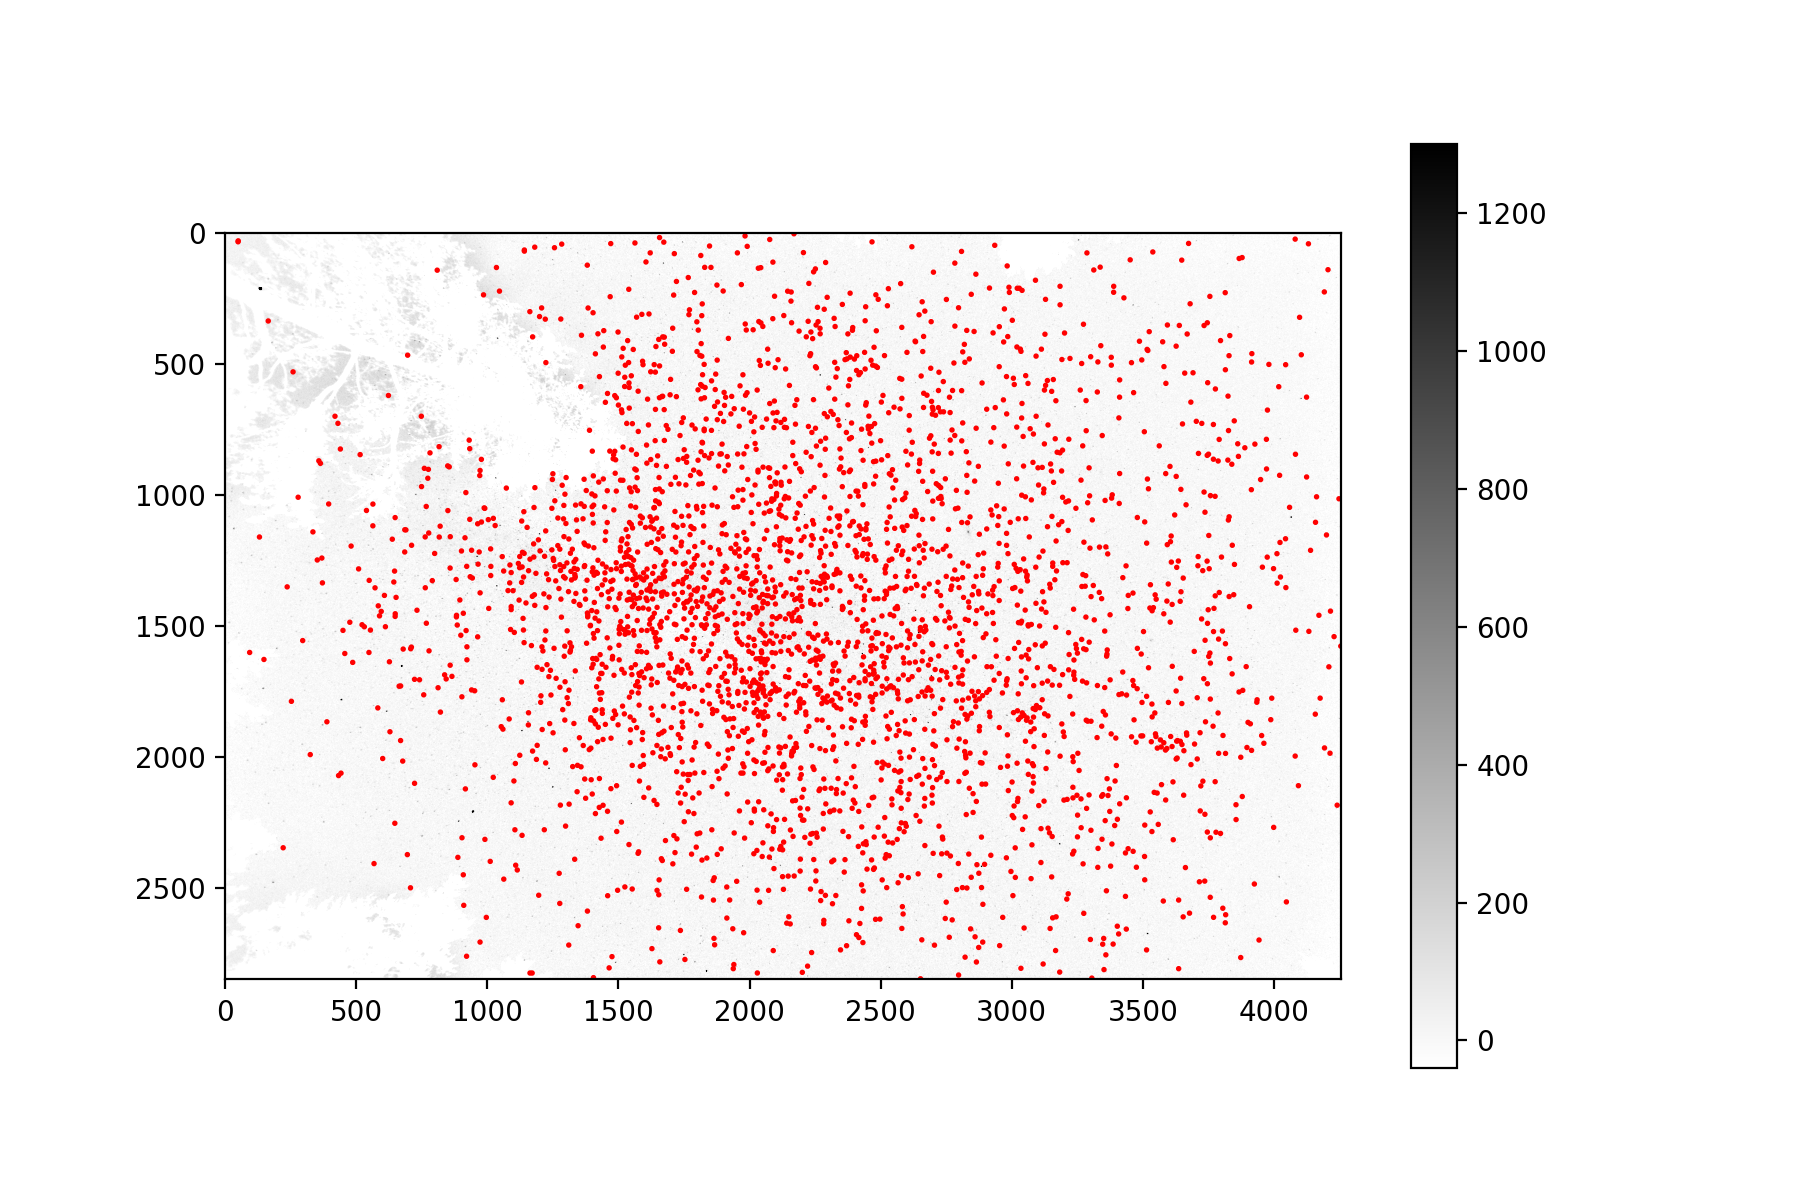

In [15]:
positions = [(x,y) for x,y in zip(sources['xcentroid'], sources['ycentroid'])]
apertures = CircularAperture(positions, r=5.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap = apertures.plot(color='red')

## Statistical analysis

In [16]:
# optimization functions
def stats(table):
    mean_roundness = np.average(table['roundness1'])
    mean_sharpness = np.average(table['sharpness'])
    
    print(mean_roundness)

    return abs(mean_roundness)

def objective_function(coeffs):
    
    red_norm = coeffs[0]
    blue_norm = coeffs[1]
    
    raw_norm_1 = imarray * (red_mask * red_norm)
    raw_norm_2 = raw_norm_1 + imarray * (green_mask * 1.0)
    raw_norm = raw_norm_2 + imarray * (blue_mask * blue_norm)
    
    raw_norm = np.where(imarray > 16380, imarray, raw_norm)
    
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = ModeEstimatorBackground()
    bkg = Background2D(raw_norm, (100, 100), filter_size=(5, 5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    subtracted = raw_norm - bkg.background
    
    daofind = DAOStarFinder(fwhm=3.0, threshold=10.*bkg.background_rms_median)  
    sources = daofind(subtracted)
    
    return stats(sources)  

In [17]:
# res = minimize(objective_function, (1.3, 1.3), method='Nelder-Mead', tol=1e-2)
# print(res.x, res.fun)

### Conclusion

It appears that optimizing for sharpness or roundness doesn't lead to any significant gain in star image conditioning. Too high sharpness causes star images to become crosses. Too low roundness discards a lot of apparently good star images. 

Assuming that DAOfind is optimizing for a Gaussian profile, we can safely assume that the best approach is to optimize for minimum background scatter and leave it at that.

## Correlate two contiguous images

In [18]:
fname2 = '../astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03780.ARW'
raw2 = rawpy.imread(fname2)
imarray2 = raw2.raw_image_visible.astype(float)

In [19]:
raw_norm_1_2 = imarray2 * (red_mask * red_norm)
raw_norm_2_2 = raw_norm_1_2 + imarray2 * (green_mask * 1.0)
raw_norm2 = raw_norm_2_2 + imarray2 * (blue_mask * blue_norm)

raw_norm2 = np.where(imarray2 > 16380, imarray2, raw_norm2)

sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = ModeEstimatorBackground()
bkg2 = Background2D(raw_norm2, (100, 100), filter_size=(5, 5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
subtracted2 = raw_norm2 - bkg2.background

daofind = DAOStarFinder(fwhm=3.0, threshold=10.*bkg2.background_rms_median)  
sources2 = daofind(subtracted2)

In [20]:
for col in sources2.colnames:  
    sources2[col].info.format = '%.4g'  # for consistent table output
print(sources2)  

 id  xcentroid ycentroid sharpness roundness1 ... sky    peak    flux   mag   
---- --------- --------- --------- ---------- ... --- --------- ----- --------
   1      2169       4.1    0.6262      0.205 ...   0      1155 1.254  -0.2459
   2      4079     24.25     0.682    -0.1512 ...   0     962.5 1.207  -0.2039
   3      2076     25.64    0.9588     0.5599 ...   0 1.268e+04 11.09   -2.613
   4      3493     25.96    0.5592     -0.363 ...   0     734.5 1.005 -0.00547
   5      3251     29.48    0.4702    -0.2496 ...   0      2737 3.893   -1.476
   6      2523     30.01    0.7406     0.1409 ...   0      1059   1.1   -0.103
   7      3700     32.05    0.5738    -0.2511 ...   0     815.7 1.052 -0.05454
   8     47.41     34.41    0.5818     0.8735 ...   0      1383 1.116  -0.1192
   9      2466     34.91    0.8207     -0.166 ...   0      9794 9.757   -2.473
  10      1742     37.25    0.9573     0.4062 ...   0      3167 2.936   -1.169
 ...       ...       ...       ...        ... ... ..

<IPython.core.display.Javascript object>


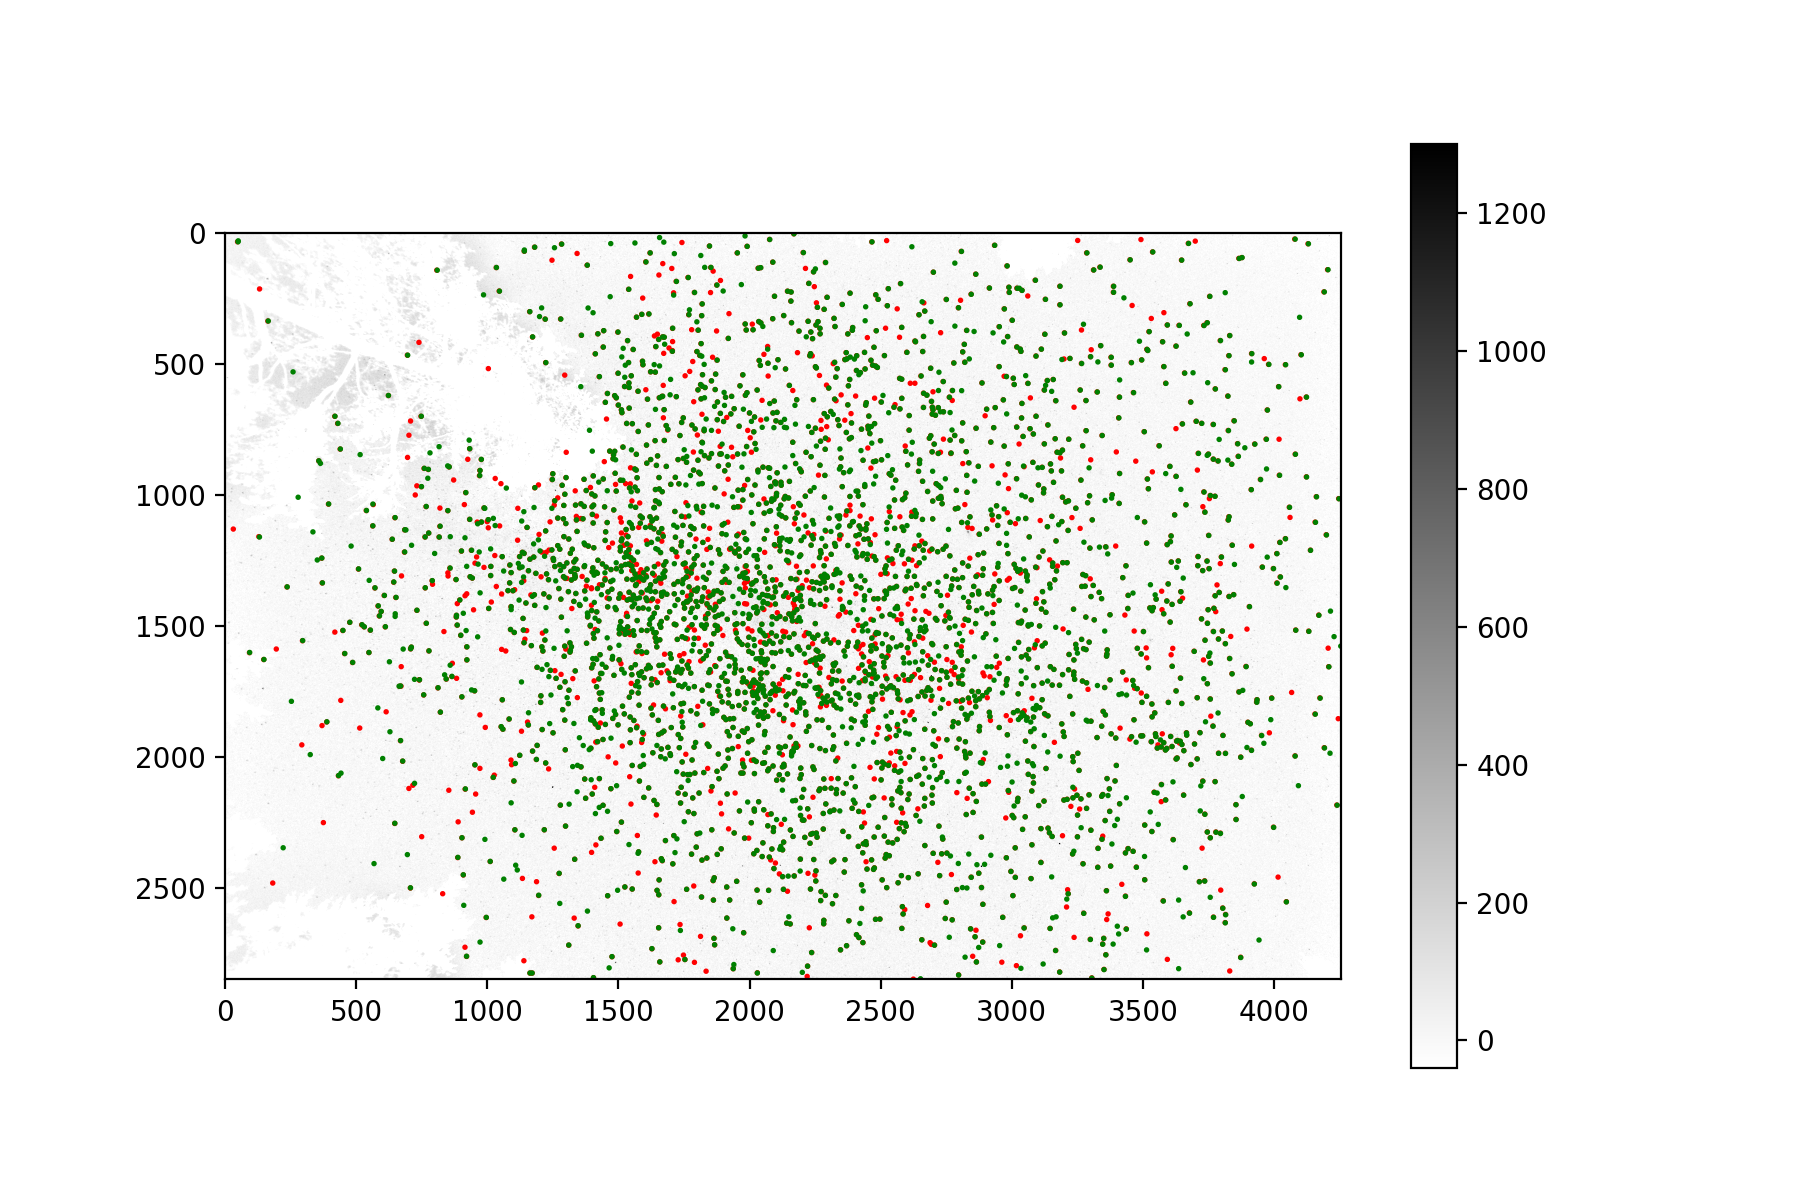

In [21]:
positions2 = [(x,y) for x,y in zip(sources2['xcentroid'], sources2['ycentroid'])]
apertures2 = CircularAperture(positions2, r=5.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted2, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap2 = apertures2.plot(color='red')
ap_ = apertures.plot(color='green') # first image

### Build table with offsets in star positions

First thing to do is to find each pair of stars, one in each table.

For that, we use the centroid positions: for every star in the first table, look for the one star in the second table whose position differs by less than 1 pixel (in both X and Y coords).

We also store the `id` (row number) of the reference (first) table, in a column of the second table. The refererence image won't have the `ref_id` column.

In [22]:
sources2.add_column(np.nan, name='xoffset')
sources2.add_column(np.nan, name='yoffset')
sources2.add_column(0, name='ref_id')

for row_index in range(len(sources)):
    x = sources[row_index]['xcentroid']
    y = sources[row_index]['ycentroid']
    
    for row2_index in range(len(sources2)):
        x2 = sources2[row2_index]['xcentroid']
        y2 = sources2[row2_index]['ycentroid']
        x_off = x2 - x
        y_off = y2 - y
        if abs(x_off) <= 1.5 and abs(y_off) <= 1.5:
            sources2[row2_index]['xoffset'] = x_off
            sources2[row2_index]['yoffset'] = y_off
            sources2[row2_index]['ref_id'] = row_index
            break

In [23]:
for col in sources2.colnames:  
    sources2[col].info.format = '%.5g'  # for consistent table output
print(sources2)  

 id  xcentroid ycentroid sharpness ...    mag      xoffset  yoffset  ref_id
---- --------- --------- --------- ... ---------- --------- -------- ------
   1    2168.6       4.1    0.6262 ...   -0.24594  -0.78324 0.097746      0
   2    4078.9    24.246   0.68202 ...   -0.20393       nan      nan      0
   3    2076.2    25.644   0.95877 ...    -2.6126  -0.74569 -0.12239      4
   4    3492.6     25.96   0.55919 ... -0.0054704       nan      nan      0
   5    3251.4    29.482   0.47022 ...    -1.4757       nan      nan      0
   6    2522.8    30.014   0.74059 ...   -0.10305       nan      nan      0
   7    3699.7    32.051   0.57384 ...   -0.05454       nan      nan      0
   8    47.412    34.411   0.58184 ...   -0.11917       nan      nan      0
   9    2466.2    34.913    0.8207 ...    -2.4733  -0.79637 0.052895      7
  10    1742.1    37.249   0.95726 ...    -1.1693       nan      nan      0
 ...       ...       ...       ... ...        ...       ...      ...    ...
3071    3831

In [24]:
# stats
print(np.nanmean(sources2['xoffset']), np.nanstd(sources2['xoffset']))
print(np.nanmean(sources2['yoffset']), np.nanstd(sources2['yoffset']))
print(np.count_nonzero(~np.isnan(sources2['xoffset'])))

-0.48662849103432587 0.2751853018089693
-0.01666124141494117 0.28352644647135034
2398


<IPython.core.display.Javascript object>


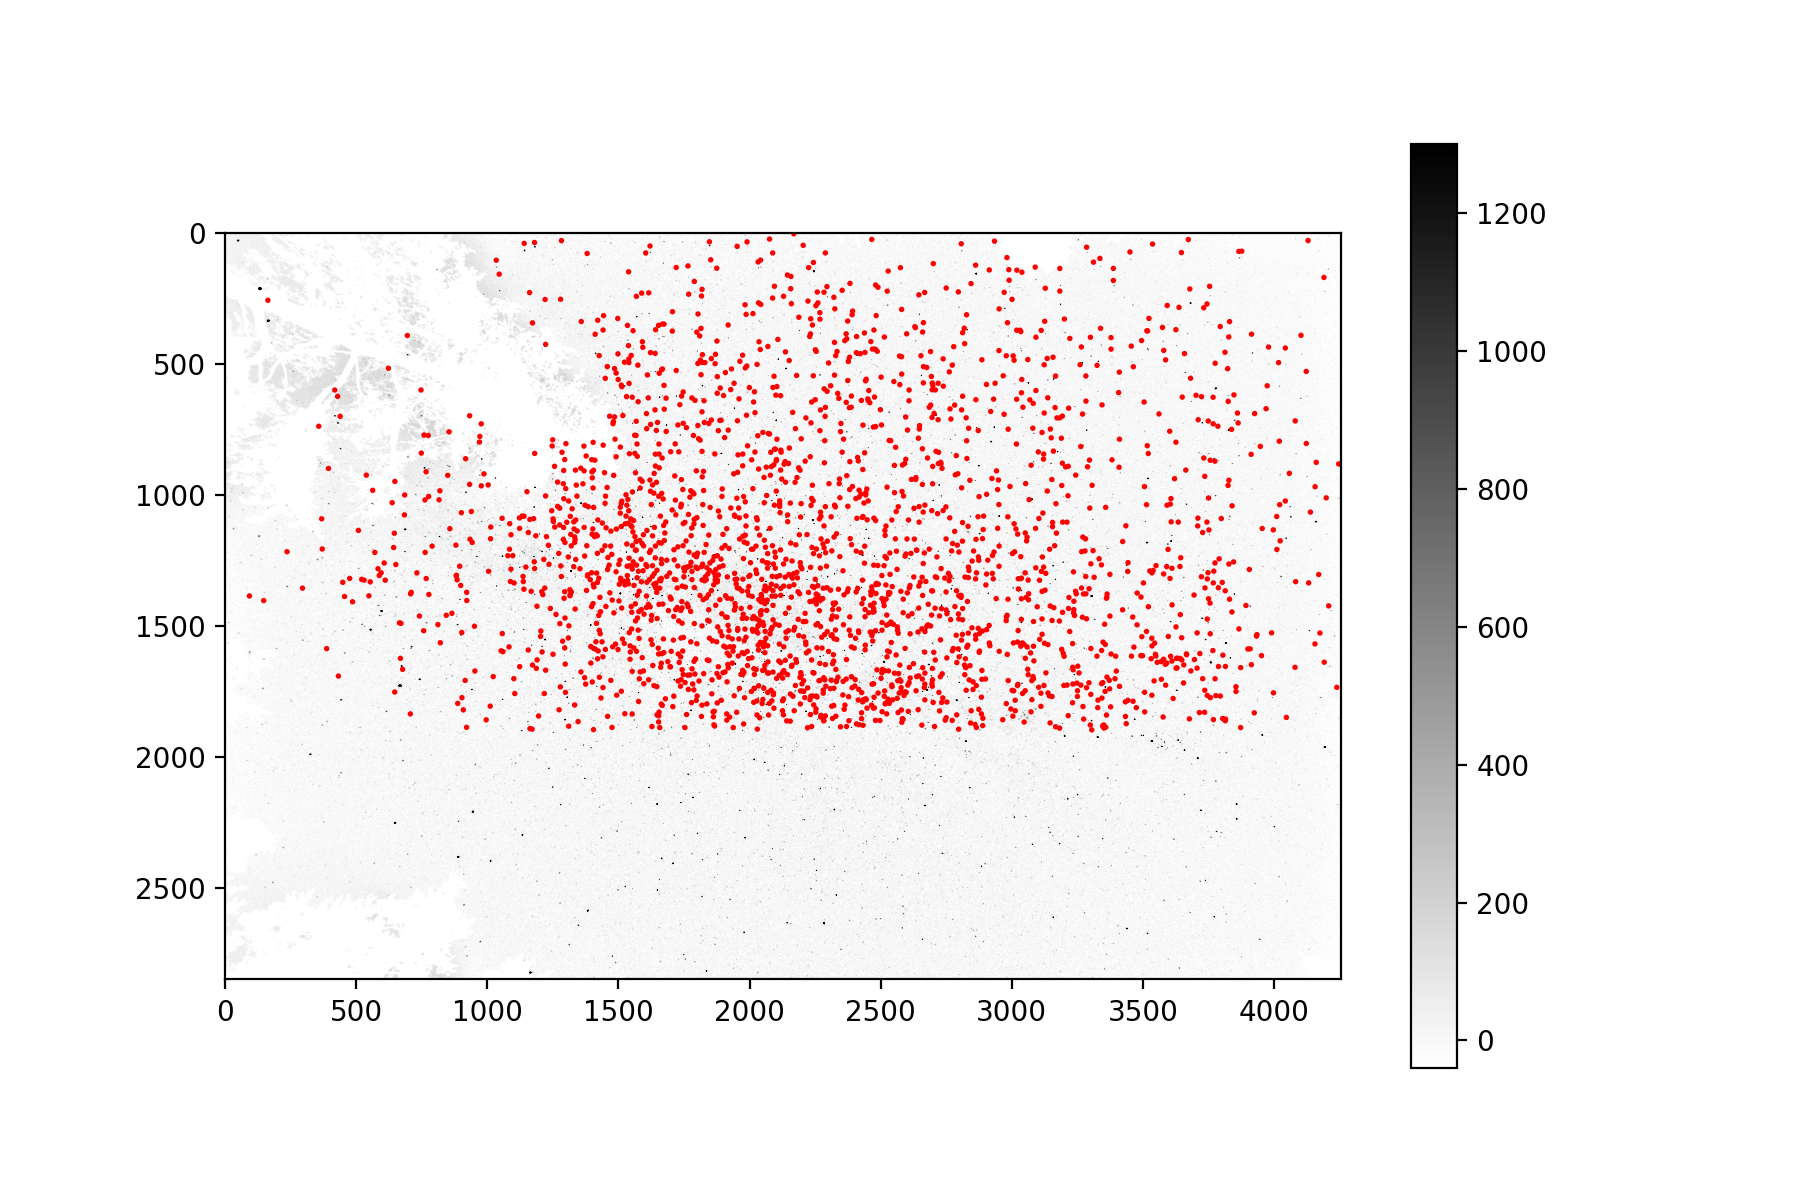

2398

In [31]:
# plot non-NaN pairs
has_nan = np.zeros(len(sources2), dtype=bool)
xoff = np.array(sources2['xoffset'])
has_nan |= np.isnan(xoff)
sources2_no_nan = sources2[~has_nan]

positions2_n = [(x,y) for x,y in zip(sources2_no_nan['xcentroid'], sources2['ycentroid'])]
apertures2_n = CircularAperture(positions2_n, r=5.)
plt.figure(figsize=[9, 6])
plt.imshow(subtracted2, vmin=-40, vmax=1300, cmap='binary')
plt.colorbar()
ap2_n = apertures2_n.plot(color='red')
len(ap2_n)

In [26]:
for col in sources2_no_nan.colnames:  
    sources2_no_nan[col].info.format = '%.5g'  # for consistent table output
print(sources2_no_nan)

 id  xcentroid ycentroid sharpness ...    mag     xoffset   yoffset  ref_id
---- --------- --------- --------- ... --------- --------- --------- ------
   1    2168.6       4.1    0.6262 ...  -0.24594  -0.78324  0.097746      0
   3    2076.2    25.644   0.95877 ...   -2.6126  -0.74569  -0.12239      4
   9    2466.2    34.913    0.8207 ...   -2.4733  -0.79637  0.052895      7
  11    3673.1     40.58   0.56888 ... -0.041873   -1.1556  -0.23393     11
  12    4129.9    42.031   0.39072 ...  -0.72583   -1.4439  -0.14947     12
  13    1282.5    43.261   0.83831 ...  -0.45273   -1.0629  -0.12652     13
  14      2934    47.925   0.32773 ...  -0.37945  -0.94564 -0.036049     14
  15    1846.8    50.788    0.4902 ...    -2.277  -0.54032  0.071589     15
  16    1990.3    51.919   0.41183 ...  -0.51307  -0.66888  -0.05371     16
  17    1179.8    55.217   0.98853 ...   -2.0249  -0.86998   0.19711     18
 ...       ...       ...       ... ...       ...       ...       ...    ...
3064    2865

In [30]:
# why not all points are plotted?
print(np.max(sources2_no_nan['xcentroid']))
print(np.max(sources2_no_nan['ycentroid']))

4246.614543756199
2841.8259049333983


### Add third image in sequence

The table associated to this image should contain offsets in relation to the first image. But to find star pairs, the code must use the second image. That is, the image immediately before it in the time sequence.

This will require perhaps a more complicated set of nested loops. 

We may want to add the image name (or path) to the table header.